In [1]:
"""imported libraries & modules & classes:"""
import os

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import skewnorm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

2024-06-12 13:33:38.715542: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 13:33:39.473548: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# check whether GPU(s) is(are) supported: the output needs to contain entries with "GPU"
# TODO: in case no GPU displayed and the hosting machine is Linux, make sure to activate GPU usage
# (e.g. for Google Colab: Menu->Laufzeit->Laufzeittyp ändern-> Hardwarebeschleuniger -> T4 GPU)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print()
# display the number of online CPUs
import multiprocessing
num_of_cores = multiprocessing.cpu_count()
print(num_of_cores)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4118124257029613147
xla_global_id: -1
]

8


2024-06-12 13:33:55.682766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-12 13:33:55.689310: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# upzipping the zip-archive of the entire raw dataset
# CASE 1: stored on the mounted Google Drive to the Google Colab's local directory
# TODO: replace the path with your full path to the .zip file
# TODO: in order to access the shared resources i.e. those outside of "/content/drive/My Drive", the respective shortcut has to be created & stored in "/content/drive/My Drive" in advance
#!unzip -qq "/content/drive/My Drive/raw.zip" # ACHTUNG: run this only once per Google Colab session
# CASE 2: stored on the local machine (here: mine with Linux OS)
!unzip -qq "/home/alex/Desktop/Prj/Data/raw.zip" -d "/home/alex/Desktop/Prj/Data" # ACHTUNG: run this only once

In [6]:
"""declaring the variable pointing to directory containing the (unzipped) dataset"""
# ACHTUNG: for 'tensorflow' to be able to (effectively) work with the dataset, it has to be organized in directories representing labels/classes containing respective images
# CASE 1: path to the directory, located/stored on Google Drive (or another repository with the resources shared with Google Drive and duly linked via shortcut)
# TODO: replace the arguments with your full path directory names
#dataset_dir = os.path.join(os.sep,"content","drive","My Drive","raw")
# CASE 2: path to the directory, located/stored on Google Colab's local directory:
#dataset_dir = os.path.join(os.sep, "content", "raw")

# CASE 3: path to the directory, stored on the local machine (here: mine with Windows OS)
# TODO: replace the arguments with your full path directory names
# TODO: for Unix systems, erase the first argument
#dataset_dir = os.path.join("C:",os.sep,"Users","jeos","Prj","WB","DST","DS","data","raw")

# CASE 4: path to the directory, stored on the local machine (here: mine with Linux OS)
# TODO: replace the arguments with your full path directory names
# TODO: for Unix systems, erase the first argument
dataset_dir = os.path.join(os.sep,"home","alex","Desktop","Prj","Data","raw")

In [7]:
# defining the path for saving the (best) model:
# CASE 1: path to the directory, located/stored on Google Drive (or another repository with the resources shared with Google Drive and duly linked via shortcut)
#model_save_path_to_file = os.path.join(os.sep,"content","drive","My Drive","model.keras")

# CASE 2: path to the directory, stored on the local machine (here: mine with Windows OS)
# TODO: replace the arguments with your full path directory names
# TODO: for Unix systems, erase the first argument
#model_save_path_to_file = os.path.join("C:",os.sep,"Users","jeos","Prj","WB","DST","DS","model.keras")

# CASE 3: path to the directory, stored on the local machine (here: mine with Linux OS)
# TODO: replace the arguments with your full path directory names
# TODO: for Unix systems, erase the first argument
model_save_path_to_file = os.path.join(os.sep,"home","alex","Desktop","Prj","model.keras")

In [12]:
"""OPTIMAL WAY of splitting the dataset: batch-wise loading of image files & labels/metadata from storage into (RA-)memory"""
px_rescale = 1./255
seed_train_validation = 123321 # Must be same for train_ds and val_ds
labels = "inferred" # default value: takes respective image-containing folder names as (class) labels
label_mode = "int" # default value: encodes fetched (class) labels numerically -> used for 'sparse_categorical_crossentropy' loss
shuffle_value = True
validation_split = 0.3 # widely-used {validation,test}/{train,validation,test} ratio
# for CPU mode: better to shrink the batch down to 32 or 64
batch_size = 32 # GPU-appropriate batch size: 128 or 256
AUTOTUNE = batch_size # another universal option would be the constant (I guess, working like an OpenGL enumerant) 'tf.data.AUTOTUNE'
color_mode = 'grayscale' # color mode the images will be converted to upon loading (default is 'rgb' (with 3 channels))
# for CPU mode: better to resize to (128, 128)
image_size = (128, 128) # GPU-appropriate value to resize the images upon loading: (256, 256) [the best pick based on the median image size of the dataset]
interpolation = 'bilinear' # default mode of resizing the images upon loading

train_ds = tf.keras.utils.image_dataset_from_directory(
directory = dataset_dir,
labels = labels,
label_mode = label_mode,
image_size = image_size,
interpolation = interpolation,
validation_split = validation_split,
subset = "training",
seed = seed_train_validation,
color_mode = color_mode,
shuffle = shuffle_value,
batch_size = batch_size)
class_names = train_ds.class_names
n_img_labels = len(train_ds.class_names)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.image_dataset_from_directory(
directory = dataset_dir,
labels = labels,
label_mode = label_mode,
image_size = image_size,
interpolation = interpolation,
validation_split = validation_split,
subset = "validation",
seed = seed_train_validation,
color_mode = color_mode,
shuffle = shuffle_value,
batch_size = batch_size)

val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3) #takes (2/3 of 30% = 20% of dataset) elements up to a specified position starting from the first element
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.skip((2*val_batches) // 3) #skips (i.e. retains the rest 10%) elements up to a specified position starting from the first element
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print('Batches for testing -->', test_ds.cardinality())
print('Batches for validating -->', val_ds.cardinality())

Found 60987 files belonging to 51 classes.
Using 42691 files for training.
Found 60987 files belonging to 51 classes.
Using 18296 files for validation.
Batches for testing --> tf.Tensor(381, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(191, shape=(), dtype=int64)


In [9]:
# helper function that generates the (right-)skewed distribution - to be used as a random value picker for the Gaussian noise "std"
def right_skewed_distr(magnitude, pool_size, min_n, max_n):
  r = skewnorm.rvs(magnitude, size=pool_size)
  r_min = min(r)
  r_max = max(r)
  r_rng = max(r) - min(r)
  r_minmax = (r - r_min)/r_rng
  r_scaled = r_minmax *(max_n - min_n) + min_n
  return np.random.choice(r_scaled)

In [13]:
# building & compiling & [callback-supported and augmentation-enriched] learning of the sequential CNN (essentially based on LeNet-5 architecture)
n_chn = dict(rgb = 3, grayscale = 1)
input_shape = image_size + (n_chn[color_mode],)
flip_ax = "horizontal_and_vertical"
zoom_in_rng = (-0.2, 0)
contr_1plumin_rng = (0, 1)
brig_rng = (-0.2, 0.2)
skew_mgn = 100
skew_dist_size = 1000
gaus_noise_std = right_skewed_distr(skew_mgn, skew_dist_size, 0, 0.1)
lambda_L2 = 0.0001
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss = tf.keras.losses.SparseCategoricalCrossentropy()
epochs = 100

model = tf.keras.Sequential([
  #<preprocessing layers>
  #<augmentation layers>
  #tf.keras.layers.RandomFlip(flip_ax),
  #tf.keras.layers.RandomZoom(zoom_in_rng),
  #tf.keras.layers.RandomContrast(contr_1plumin_rng),
  #tf.keras.layers.RandomBrightness(brig_rng),
  #<preprocessing layer>
  tf.keras.layers.Rescaling(px_rescale),
  #</preprocessing layer>
  #tf.keras.layers.GaussianNoise(gaus_noise_std),
  #</augmentation layers>
  #</preprocessing layers>
  tf.keras.layers.Conv2D(filters = 6, kernel_size = 5, padding='valid', strides = 1, activation='relu', use_bias=True),
  tf.keras.layers.AveragePooling2D(pool_size = 2, strides = 2, padding='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Conv2D(filters = 16, kernel_size = 5, padding='valid', strides = 1, activation='relu', use_bias=True,),
  tf.keras.layers.AveragePooling2D(pool_size = 2, strides = 2, padding='valid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(rate = 0.2),
  tf.keras.layers.Conv2D(filters = 120, kernel_size = 5, padding='valid', strides = 1, activation='relu', use_bias=True, kernel_regularizer = tf.keras.regularizers.l2(l2=lambda_L2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(rate = 0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(units = 84, activation='relu', use_bias=True, kernel_regularizer = tf.keras.regularizers.l2(l2=lambda_L2)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(rate = 0.2),
  tf.keras.layers.Dense(units = n_img_labels, activation='softmax')
])

model.compile(optimizer = optimizer,
              loss = loss,
              metrics=['accuracy'])

# model (e.g. the best performing one from previous training(s)) can be loaded as:
# TODO: in case model is loaded, upper lines that build and compile the model should be commented out
#model = tf.keras.models.load_model(model_save_path_to_file)

early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                        patience = 15,
                        verbose=2,
                        mode = 'min',
                        restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=5,
                            factor=0.75,
                            verbose=2,
                            mode='min')

model_checkpoint = callbacks.ModelCheckpoint( # creates a file 'model.keras' - slows down only once during the first save
    filepath=model_save_path_to_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq = "epoch")

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs = epochs,
  callbacks = [early_stopping,lr_plateau,model_checkpoint]
)

Epoch 1/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 269s 199ms/step - accuracy: 0.4979 - loss: 1.9973 - val_accuracy: 0.1976 - val_loss: 5.2668 - learning_rate: 0.0010
Epoch 2/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 263s 197ms/step - accuracy: 0.7416 - loss: 1.1485 - val_accuracy: 0.3272 - val_loss: 3.6012 - learning_rate: 0.0010
Epoch 3/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 262s 196ms/step - accuracy: 0.6082 - loss: 1.9042 - val_accuracy: 0.7390 - val_loss: 1.4391 - learning_rate: 0.0010
Epoch 4/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 262s 196ms/step - accuracy: 0.7762 - loss: 1.3477 - val_accuracy: 0.7061 - val_loss: 1.6852 - learning_rate: 0.0010
Epoch 5/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 262s 196ms/step - accuracy: 0.7974 - loss: 1.3792 - val_accuracy: 0.7529 - val_loss: 1.5795 - learning_rate: 0.0010
Epoch 6/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 261s 196ms/step - accuracy: 0.8233 - loss: 1.3779 - val_accuracy: 0.7962 - val_loss: 1.5122 - learning_rate: 0.0010
Epoch 7/100
1335/1335 ━━━━━━━━━━━━━━━━━━━━ 261

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 124, 124, 6)    │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 62, 62, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 62, 62, 6)      │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 29, 29, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 29, 29, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 120)    │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 25, 25, 120)    │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 25, 120)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 75000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 84)             │     6,300,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 84)             │           336 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 84)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 51)             │         4,335 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,067,143 (72.74 MB)

 Trainable params: 6,355,563 (24.24 MB)

 Non-trainable params: 452 (1.77 KB)

 Optimizer params: 12,711,128 (48.49 MB)

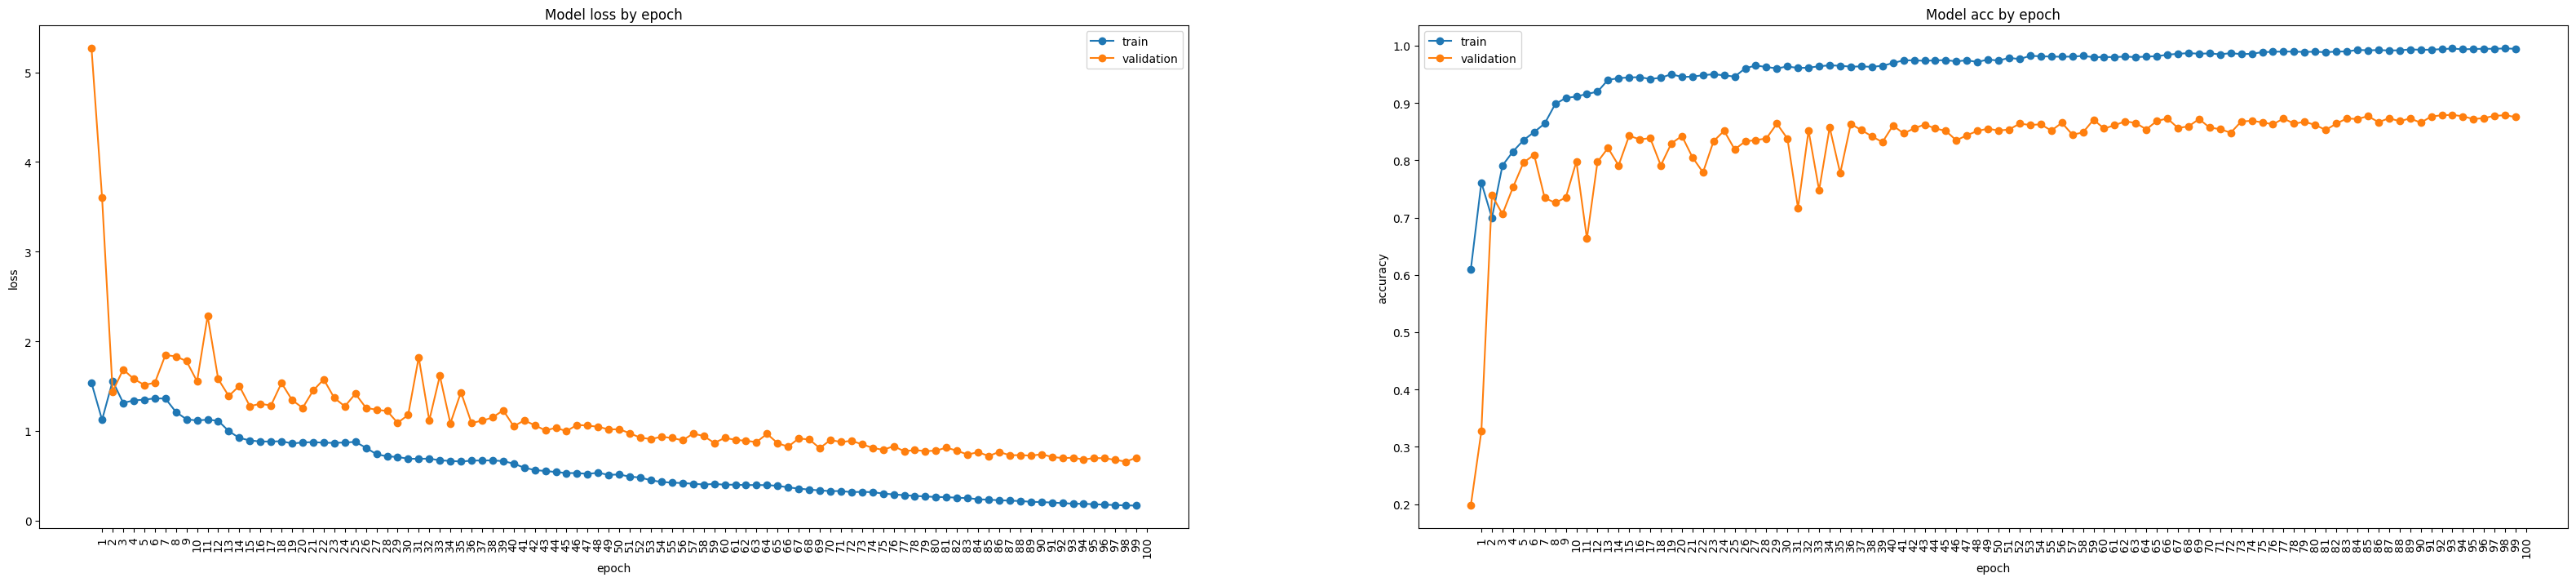

In [14]:
# display the architecture of the model showing i.a. the number of (non-)trainable parameters
model.summary()

def dflt(value, default):
    return value if value > 0 else default

xticks = np.arange(start = 1, stop = min(dflt(early_stopping.stopped_epoch, epochs), epochs) + 1)

# evolution plots of accuracies on the train and validation data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,8))

ax1.plot(history.history['loss'],'-o')
ax1.plot(history.history['val_loss'],'-o')
ax1.set_title('Model loss by epoch')
ax1.set_ylabel('loss')
ax1.set_xlabel('epoch')
ax1.set_xticks(xticks)
ax1.set_xticklabels(xticks, rotation='vertical')
ax1.legend(['train', 'validation'], loc='best')

ax2.plot(history.history['accuracy'],'-o')
ax2.plot(history.history['val_accuracy'],'-o')
ax2.set_title('Model acc by epoch')
ax2.set_ylabel('accuracy')
ax2.set_xlabel('epoch')
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticks, rotation='vertical')
ax2.legend(['train', 'validation'], loc='best')

plt.show();plt.close();

2024-06-12 21:38:23.244775: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


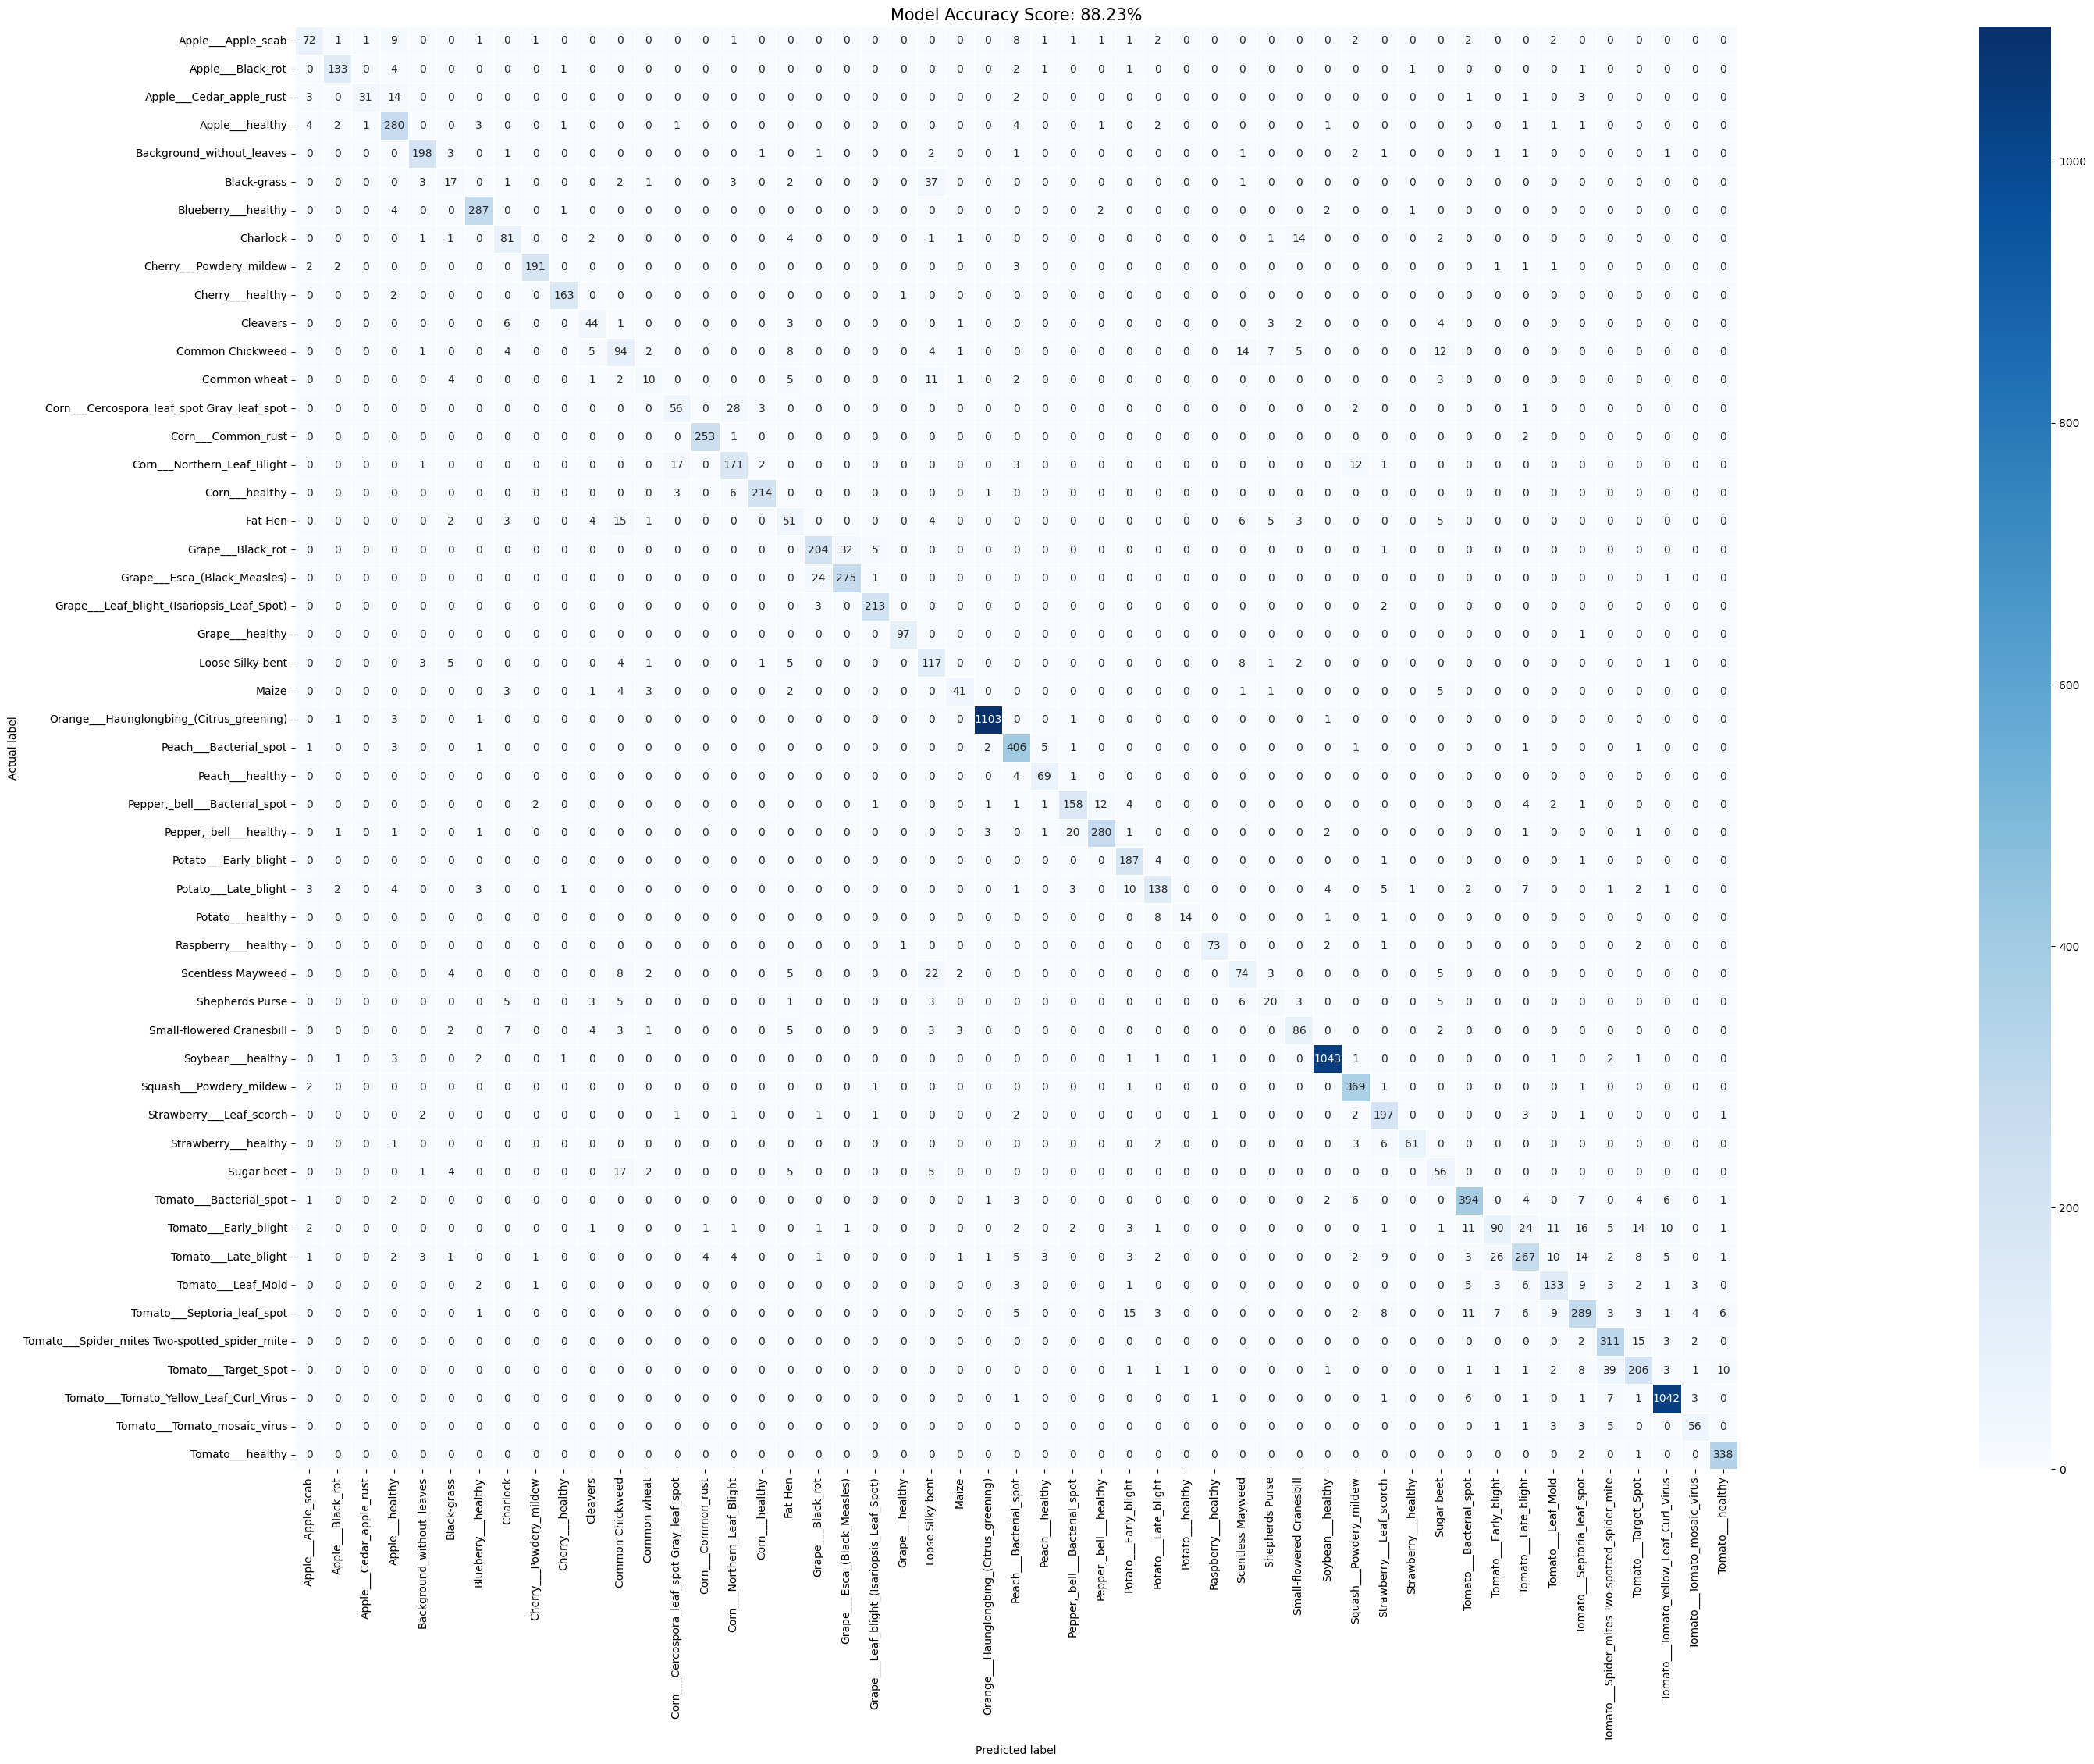

In [15]:
# predict on the test data and generate confusion matrix
test_classes = np.array([])
predicted_classes = np.array([])

for x, y in test_ds:
  predicted_classes = np.concatenate([predicted_classes, np.argmax(model(x, training=False), axis = -1)]).astype(int)
  test_classes = np.concatenate([test_classes, y.numpy()]).astype(int)

loss_acc_tuple = model.evaluate(test_ds, verbose=0) #loss_acc_tuple = (loss_acc_tuple[0], loss_acc_tuple[1]) = loss, acc
cm = confusion_matrix(test_classes, predicted_classes)

plt.figure(figsize=(80,24))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show();plt.close();

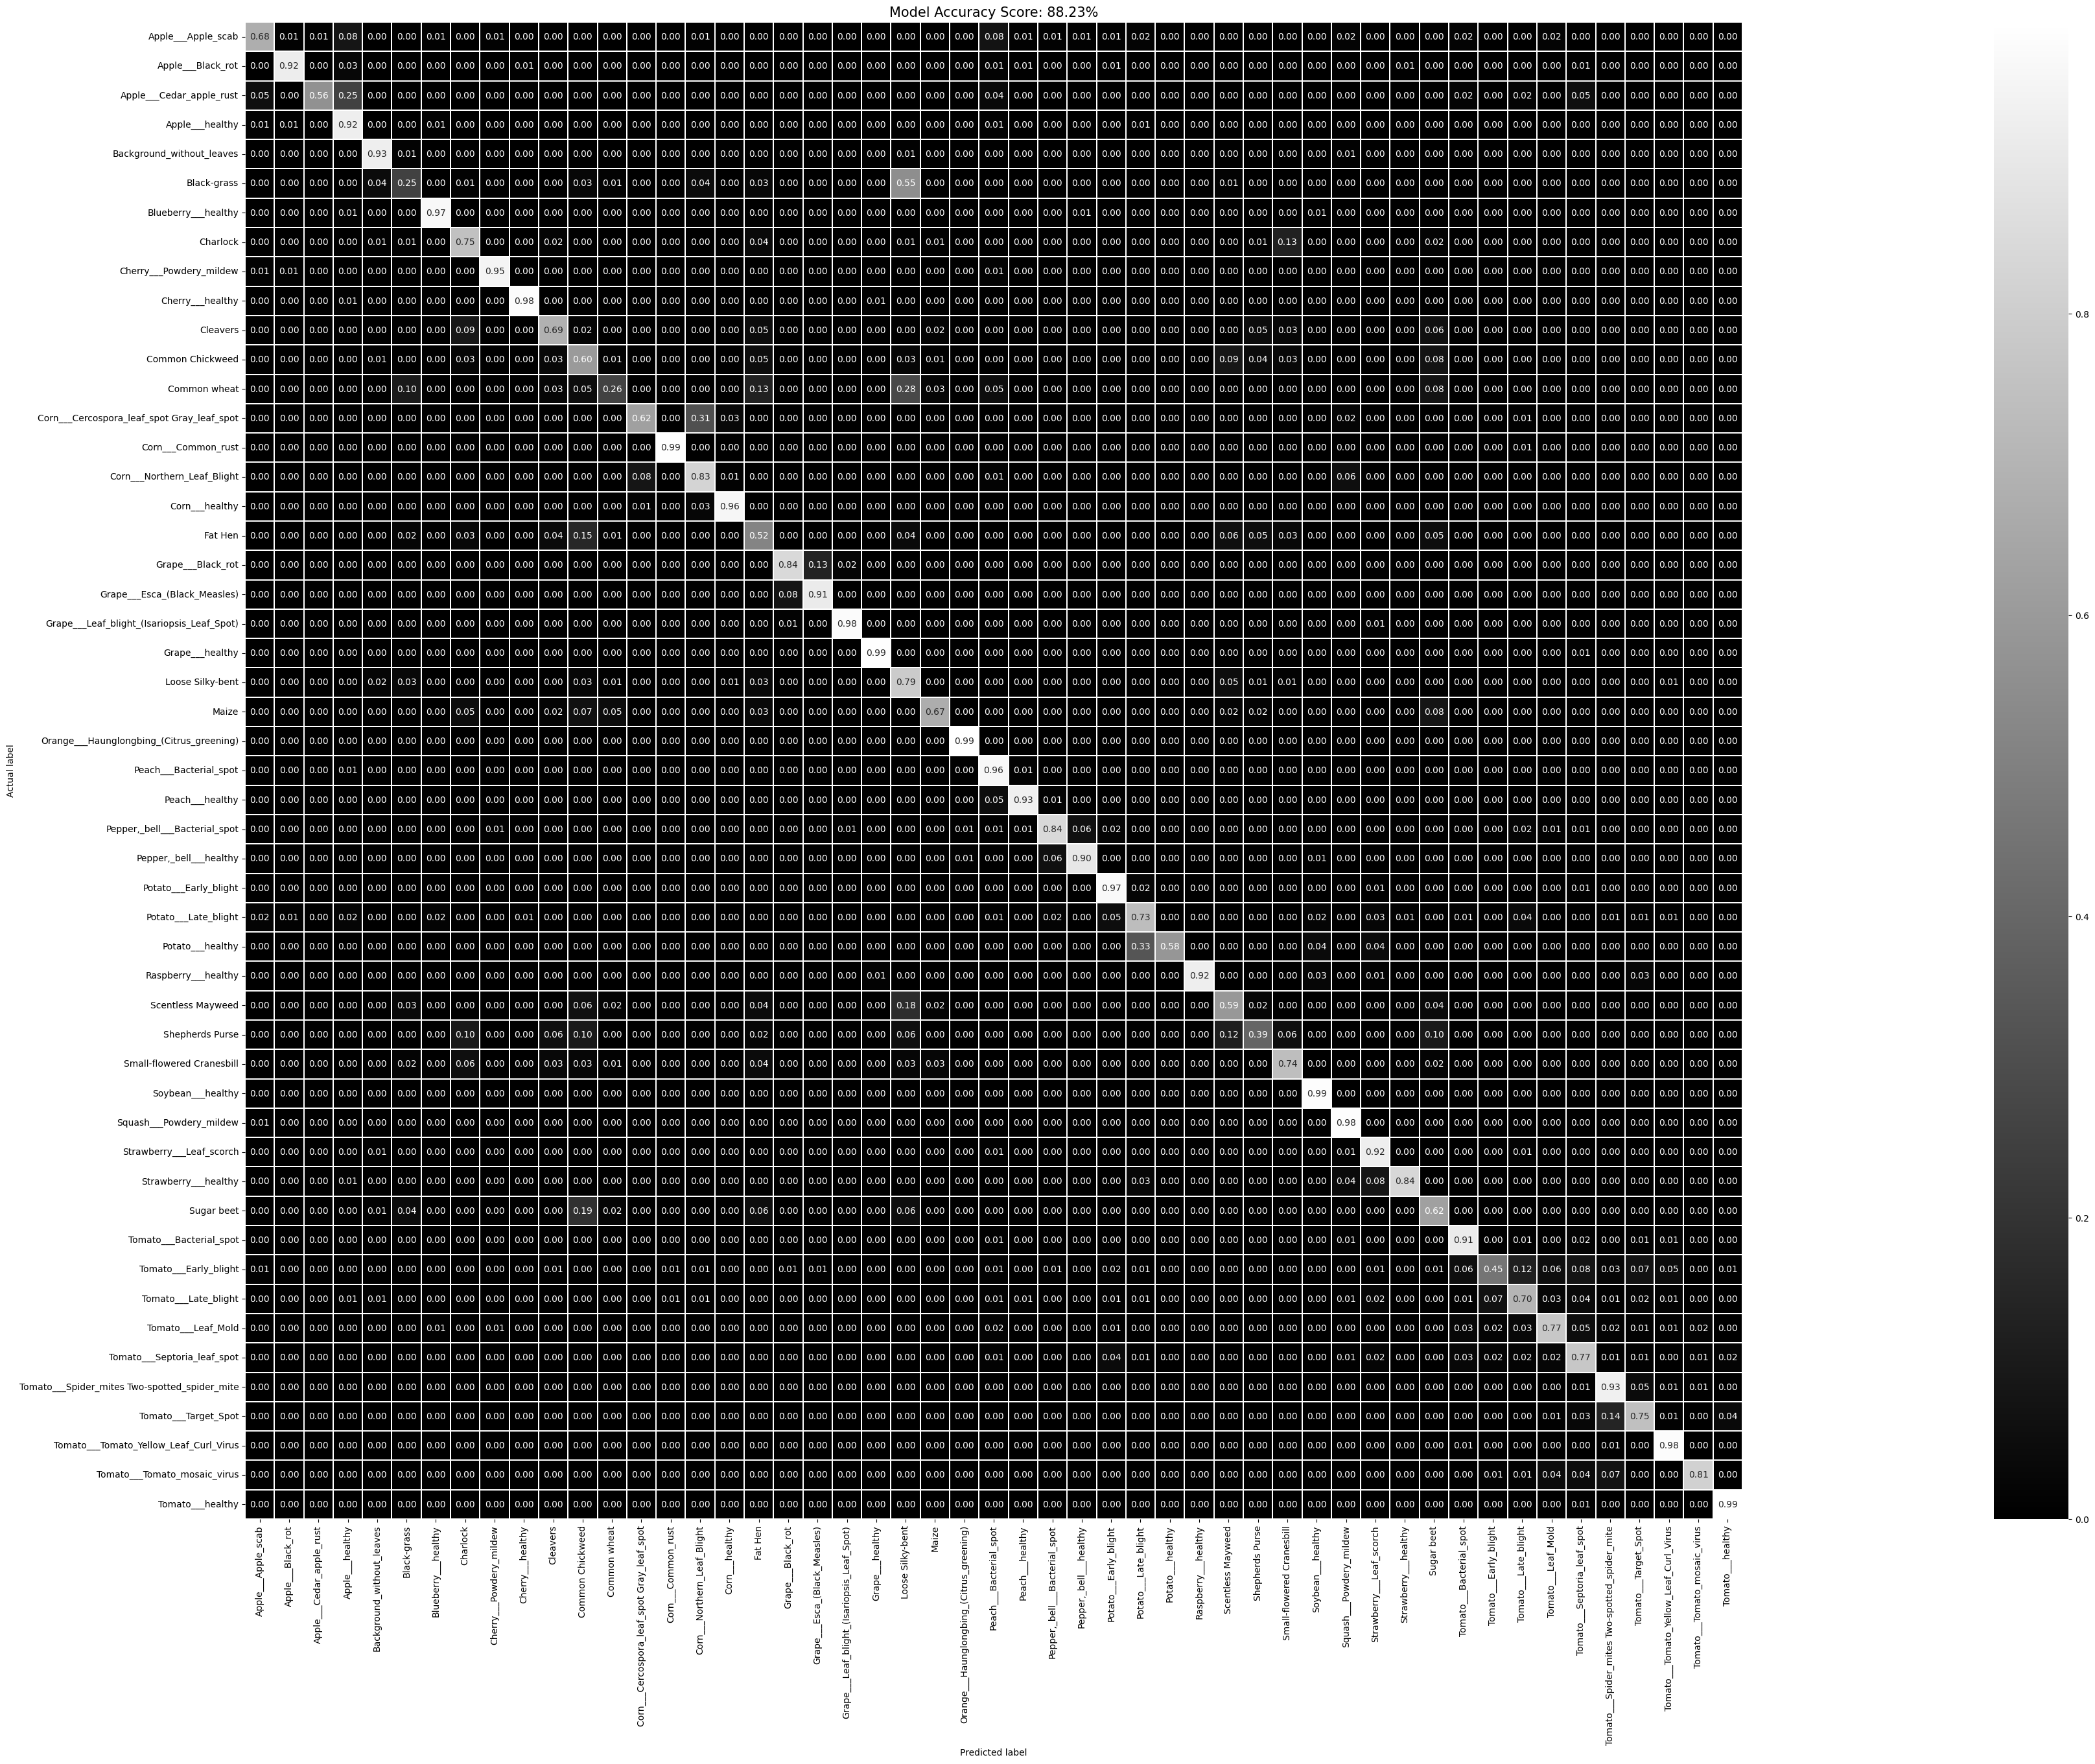

In [16]:
# plot confusion matrix, normalized over actual classes (i.e. rows)
cm_nrm_tr = confusion_matrix(test_classes, predicted_classes, normalize = "true")

plt.figure(figsize=(100,30))
sns.heatmap(cm_nrm_tr, annot=True, fmt=".2f", linewidths=.2, square = True, cmap = 'gray', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show();plt.close();

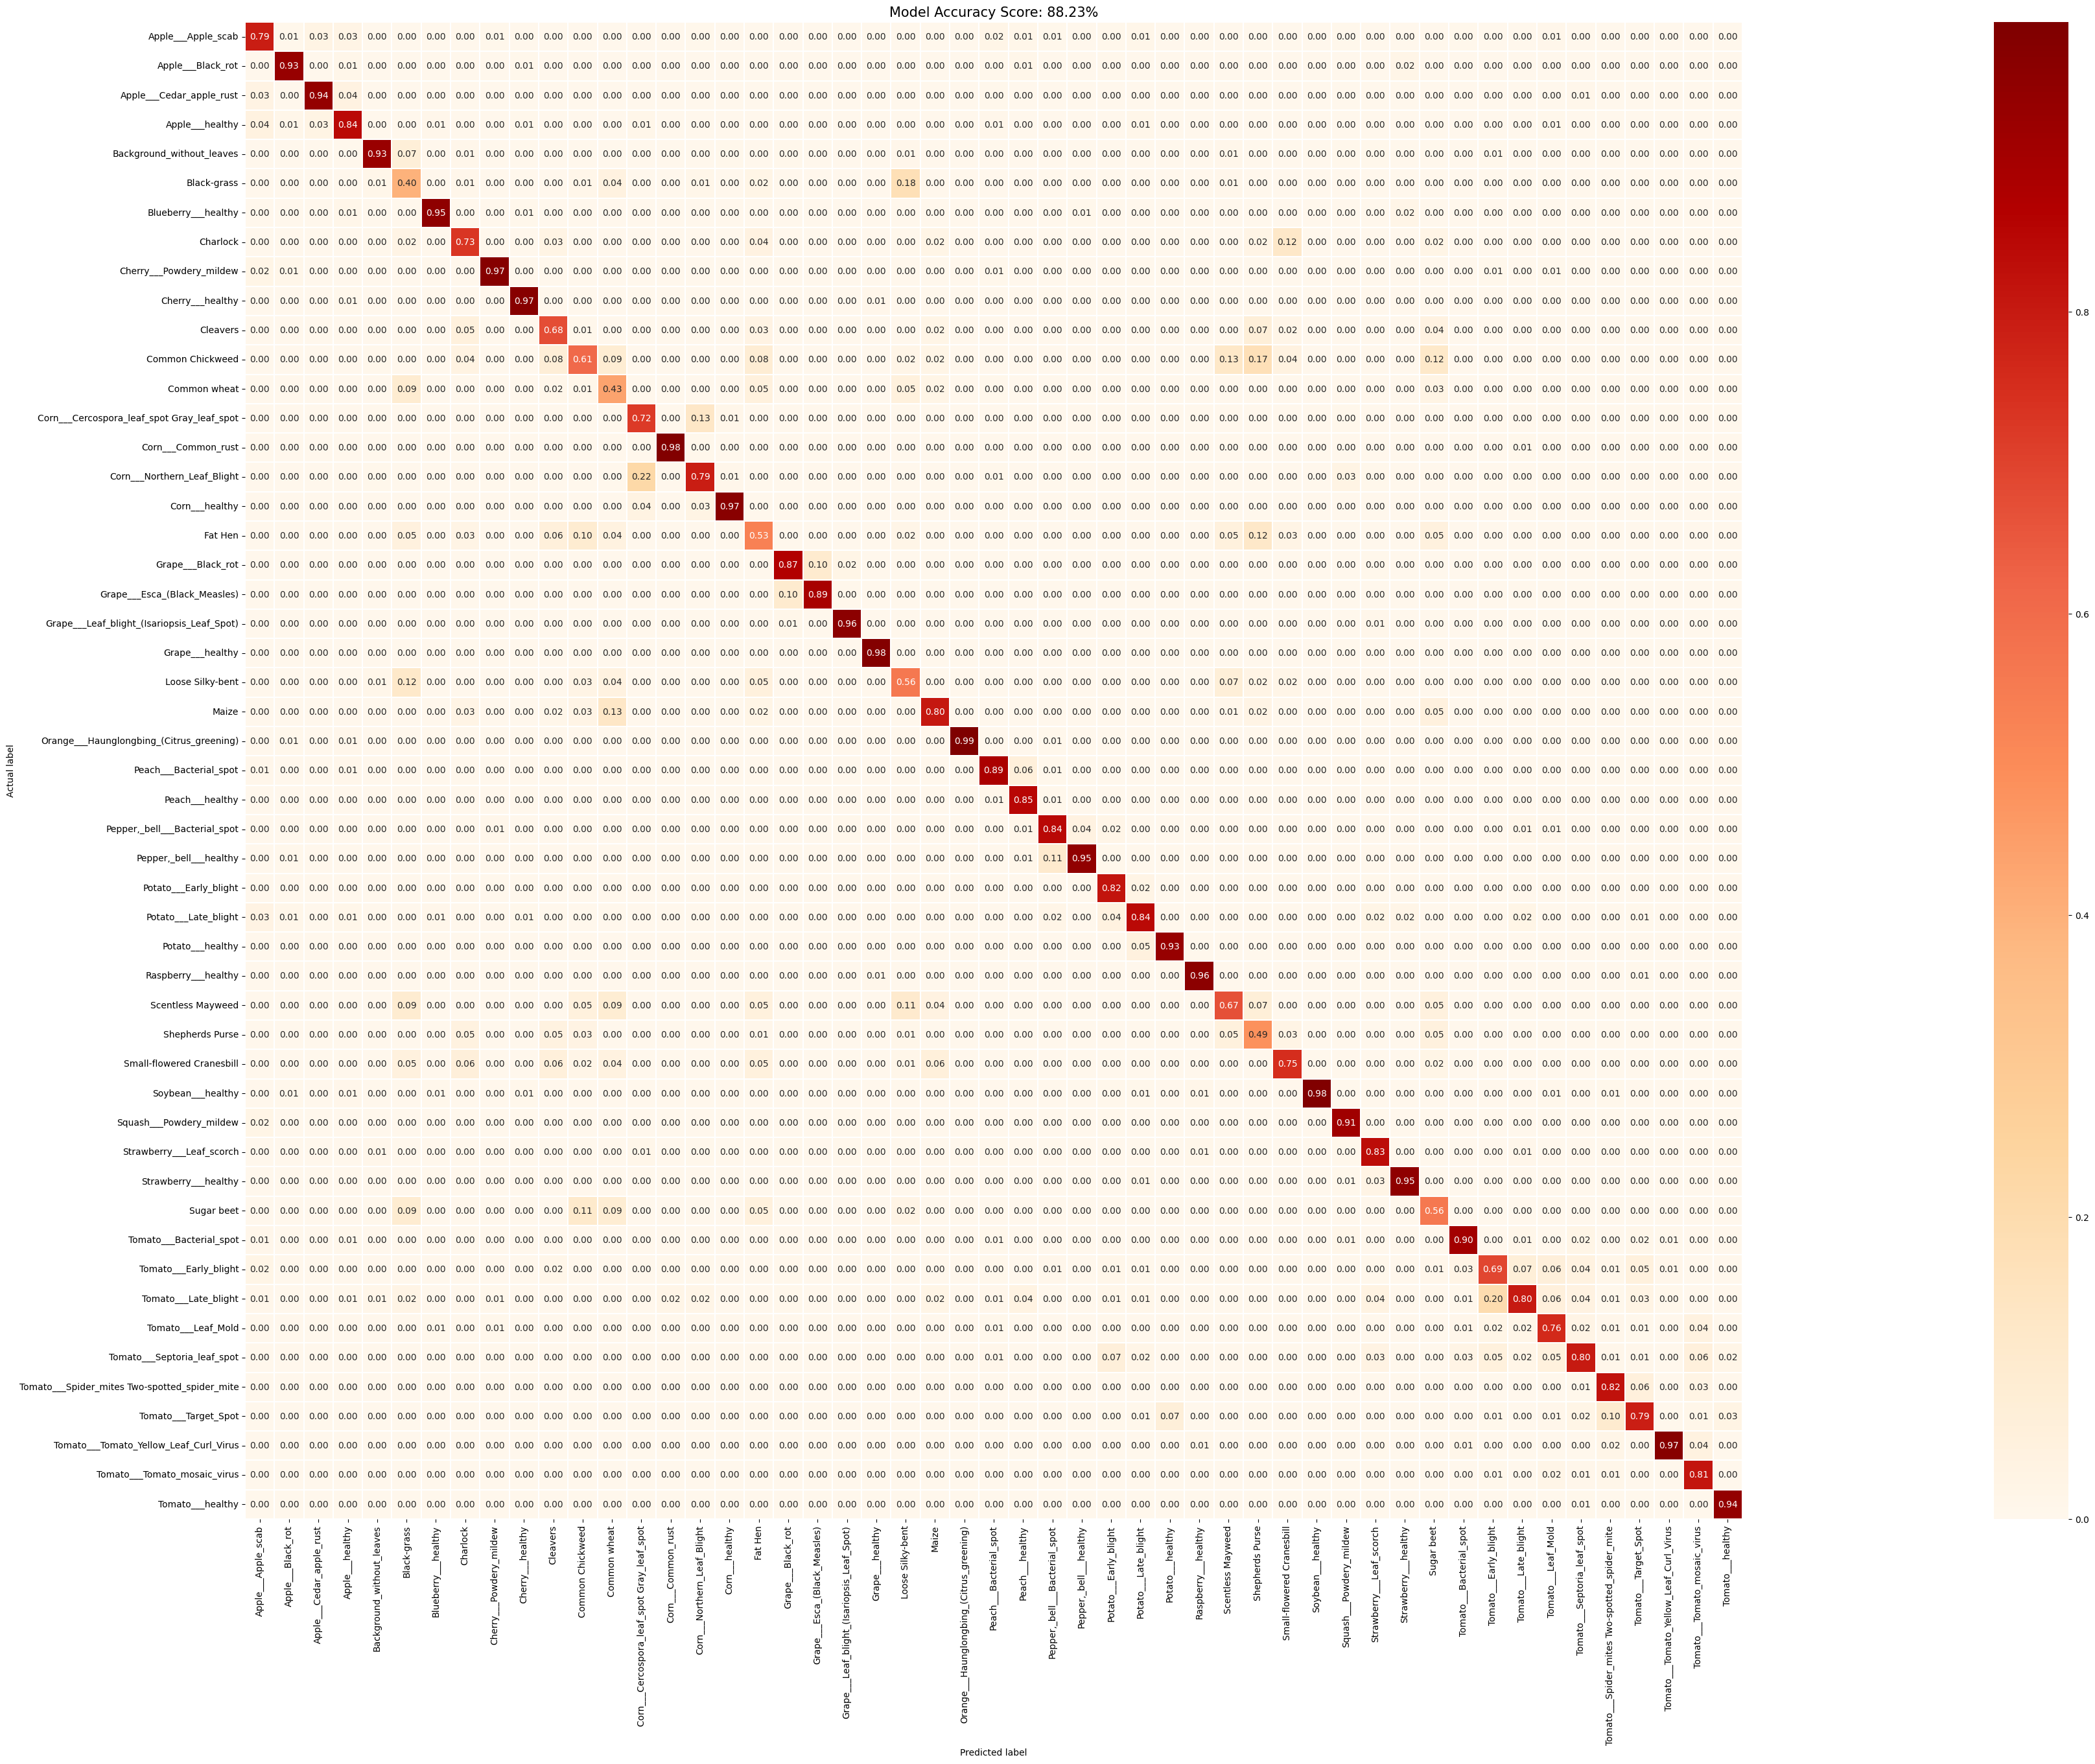

In [17]:
# plot confusion matrix, normalized over predicted classes (i.e. columns)
cm_nrm_pr = confusion_matrix(test_classes, predicted_classes, normalize = "pred")

plt.figure(figsize=(100,30))
sns.heatmap(cm_nrm_pr, annot=True, fmt=".2f", linewidths=.2, square = True, cmap = 'OrRd', yticklabels=class_names, xticklabels=class_names)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = f'Model Accuracy Score: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show();plt.close();

In [18]:
# predict on the test data and generate confusion matrix & classification report
print(classification_report(test_classes, predicted_classes, target_names=class_names, zero_division= "warn"))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.79      0.68      0.73       106
                            Apple___Black_rot       0.93      0.92      0.93       144
                     Apple___Cedar_apple_rust       0.94      0.56      0.70        55
                              Apple___healthy       0.84      0.92      0.88       303
                    Background_without_leaves       0.93      0.93      0.93       214
                                  Black-grass       0.40      0.25      0.31        67
                          Blueberry___healthy       0.95      0.97      0.96       297
                                     Charlock       0.73      0.75      0.74       108
                      Cherry___Powdery_mildew       0.97      0.95      0.96       201
                             Cherry___healthy       0.97      0.98      0.98       166
                                     Cleav

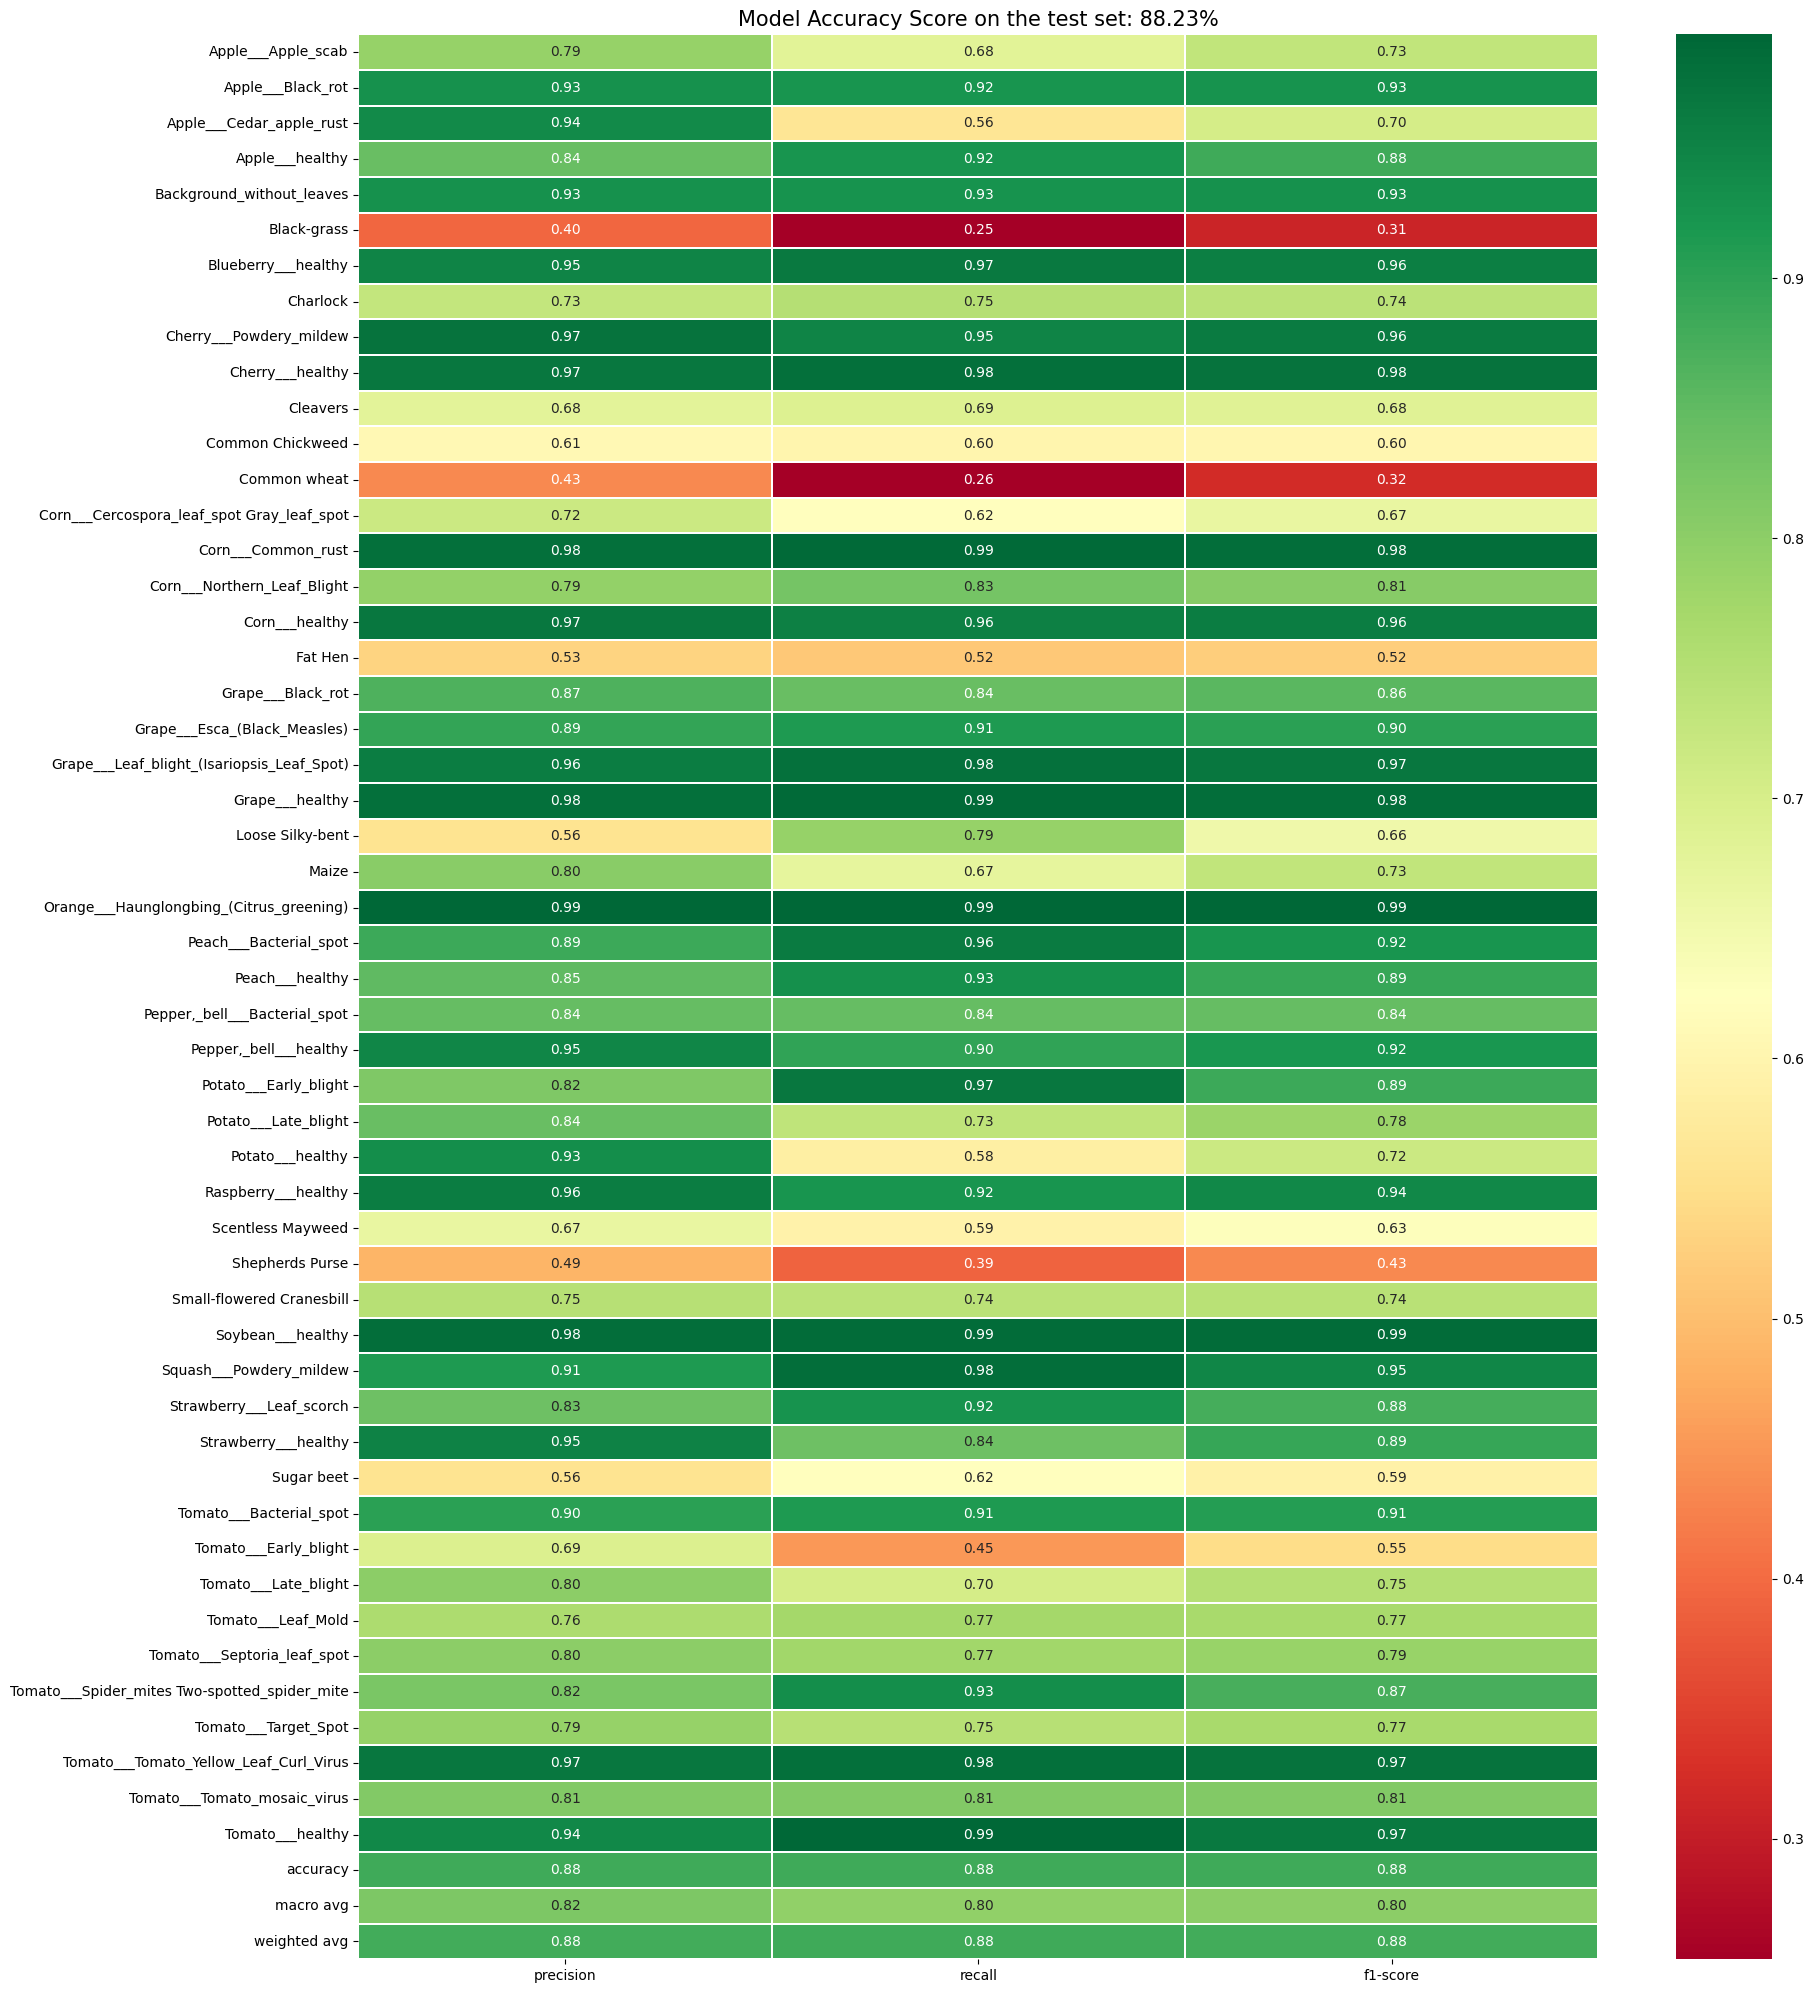

In [19]:
# plot the classification report
import pandas as pd
clf_report = classification_report(test_classes, predicted_classes, target_names=class_names, zero_division= "warn",output_dict=True)

df = pd.DataFrame(clf_report).iloc[:-1,:].T

plt.figure(figsize=(20,25))
sns.heatmap(df, annot=True, fmt=".2f", linewidths=.2, cmap = 'RdYlGn')
all_sample_title = f'Model Accuracy Score on the test set: {loss_acc_tuple[1]:.2%}'
plt.title(all_sample_title, size = 15)
plt.show();plt.close();

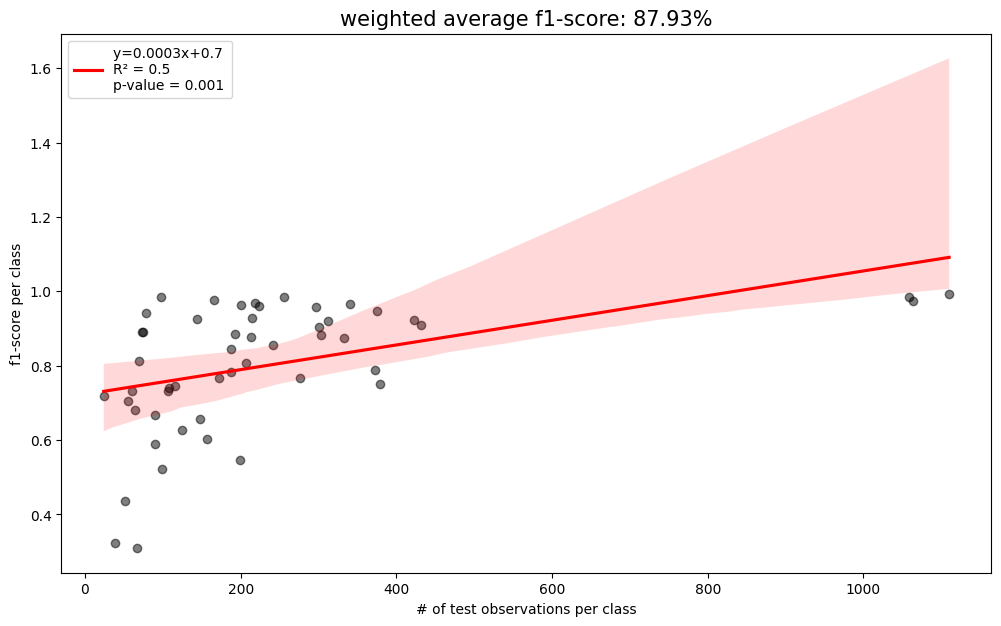

In [21]:
# plot regression model with 99% confidence interval
from sklearn.metrics import precision_recall_fscore_support as score
from scipy.stats import linregress
_,_,fscore,support = score(test_classes,predicted_classes)
_,_,fscore_wavg,_ = score(test_classes,predicted_classes,average='weighted')
slope, intercept, r_value, p_value, _ = linregress(support,fscore)

plt.figure(figsize=(12,7))
ax = sns.regplot(x = support, y = fscore,
            scatter_kws = {"color": "black", "alpha": 0.5},
            line_kws = {"color": "red", 'label':"y={0:.4f}x+{1:.1f} \nR² = {2:.1f} \np-value = {3:.3f}".format(slope,intercept,r_value, p_value)},
            ci = 99)
plt.ylabel('f1-score per class')
plt.xlabel('# of test observations per class')
all_sample_title = f'weighted average f1-score: {fscore_wavg:.2%}'
plt.title(all_sample_title, size = 15)
ax.legend()
plt.show();plt.close();

In [22]:
# saving the model on the mounted Google Drive:
model.save(model_save_path_to_file) # creates a zip archive 'model.keras'